Student name: Thi Kieu Trang (Mila) Pham

# Question 2 - Stochastic Volatility Modeling and Forecasting 

## 1. Data Collection

### 1.1. Select an individual stock from Yahoo Finance & Download daily price data for the last 15 years.

In [62]:
import yfinance as yf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [54]:
df = yf.download("AAPL", start="2009-01-01", end="2024-12-31", auto_adjust=False,
                 progress=False)
print(f"Downloaded {len(df)} rows of data.")
df

Downloaded 4025 rows of data.


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2009-01-02,2.730994,3.241071,3.251429,3.041429,3.067143,746015200
2009-01-05,2.846252,3.377857,3.435000,3.311071,3.327500,1181608400
2009-01-06,2.799307,3.322143,3.470357,3.299643,3.426786,1289310400
2009-01-07,2.738819,3.250357,3.303571,3.223571,3.278929,753048800
2009-01-08,2.789676,3.310714,3.326786,3.215714,3.229643,673500800
...,...,...,...,...,...,...
2024-12-23,254.989655,255.270004,255.649994,253.449997,254.770004,40858800
2024-12-24,257.916443,258.200012,258.209991,255.289993,255.490005,23234700


In [56]:
df = df.loc[:, ["Adj Close"]]
df

Price,Adj Close
Ticker,AAPL
Date,
2009-01-02,2.730994
2009-01-05,2.846252
2009-01-06,2.799307
2009-01-07,2.738819
2009-01-08,2.789676
...,...
2024-12-23,254.989655
2024-12-24,257.916443


### 1.2. Compute daily log returns and plot their time series

In [58]:
df["simple_rtn"] = df["Adj Close"].pct_change()
df["log_rtn"] = np.log(df["Adj Close"]/df["Adj Close"].shift(1))

In [85]:
df.head()

Price,Adj Close,simple_rtn,log_rtn
Ticker,AAPL,,
Date,,,
2009-01-02,2.730993,NaN,NaN
2009-01-05,2.846253,0.042204,0.041338
2009-01-06,2.799307,-0.016494,-0.016632
2009-01-07,2.738817,-0.021609,-0.021846
2009-01-08,2.789676,0.018570,0.018399


In [60]:
df.dropna(inplace=True)

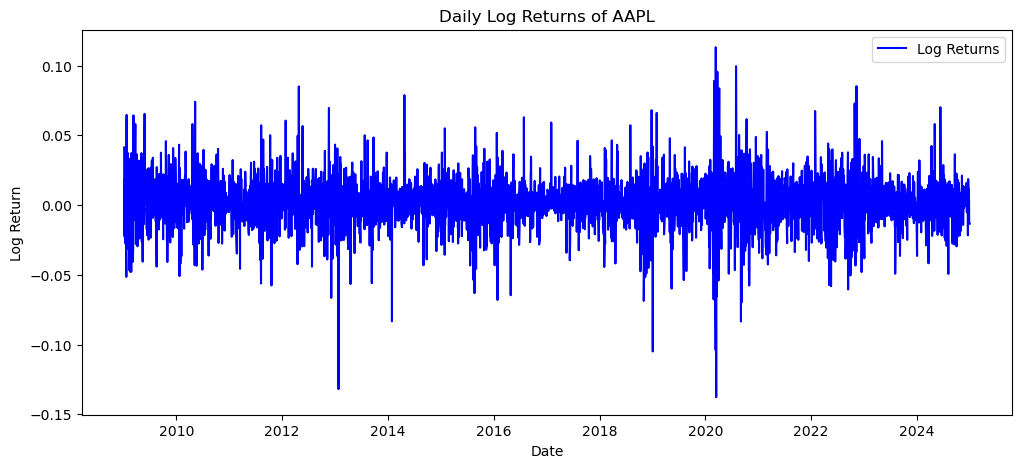

In [89]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["log_rtn"], label="Log Returns", color='blue')

plt.title("Daily Log Returns of AAPL")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.show()

- The returns fluctuate around zero, indicating that there is no long-term trend in daily returns.
- There are periods of high fluctuations (volatility clustering), meaning that large positive or negative returns tend to be followed by other large returns.
- Extreme spikes in log returns correspond to financial crises, earnings reports, or external market shocks.

In [64]:
df["Adj Close"].pct_change()

Ticker,AAPL
Date,
2009-01-05,NaN
2009-01-06,-0.016494
2009-01-07,-0.021608
2009-01-08,0.018569
2009-01-09,-0.022869
...,...
2024-12-23,0.003065
2024-12-24,0.011478
2024-12-26,0.003176


## 2. Realized Volatility Computation

### 2.1. Compute and plot realized volatility using a rolling window of 21 trading days

In [66]:
df["RV_21"] = df["log_rtn"].rolling(window=21).std() * np.sqrt(252)
df.dropna(inplace=True)
print(df.head())

Price      Adj Close simple_rtn   log_rtn     RV_21
Ticker          AAPL                               
Date                                               
2009-02-03  2.798102   0.016063  0.015936  0.487516
2009-02-04  2.815256   0.006131  0.006112  0.465718
2009-02-05  2.902828   0.031106  0.030632  0.473827
2009-02-06  3.000934   0.033797  0.033238  0.477701
2009-02-09  3.084894   0.027978  0.027594  0.482149


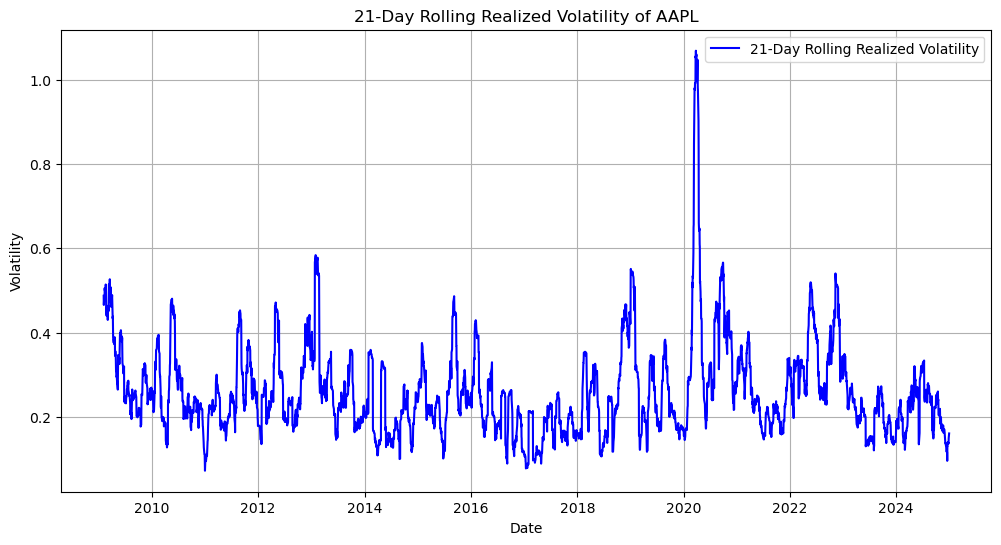

In [95]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, df["RV_21"], label="21-Day Rolling Realized Volatility", color="blue")

plt.title("21-Day Rolling Realized Volatility of AAPL")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()


### 2.2. Discuss the computed volatility

- Periods of high volatility: Around 2008-2009, high volatility likely due to the 2008 financial crisis. A large spike in 2020, corresponding to the COVID-19 market crash. Other peaks may be related to earnings announcements, macroeconomic events, or global financial crises.
- Periods of low volatility: There are periods of stable and low volatility, often during bull markets when stock prices rise steadily without major crashes.

In [68]:
df["log_rtn_scaled"] = df["log_rtn"] * 100

## 3. Stochastic Volatility Model

### 3.1. Fit an ARCH and GARCH model to the log returns

In [121]:
# Fit an ARCH(p) model with p=5
arch_p_model = arch_model(df["log_rtn_scaled"], vol="ARCH", p=5).fit(disp="off")

print(arch_p_model.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:         log_rtn_scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7724.28
Distribution:                  Normal   AIC:                           15462.6
Method:            Maximum Likelihood   BIC:                           15506.6
                                        No. Observations:                 4004
Date:                Sun, Mar 09 2025   Df Residuals:                     4003
Time:                        15:44:45   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1620  2.741e-02      5.909  3.442e-09 [  0.108,  0.21

In [123]:
# Fit a GARCH(2,2) model
garch_pq_model = arch_model(df["log_rtn_scaled"], vol="GARCH", p=2, q=2).fit(disp="off")

print(garch_pq_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:         log_rtn_scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7676.78
Distribution:                  Normal   AIC:                           15365.6
Method:            Maximum Likelihood   BIC:                           15403.3
                                        No. Observations:                 4004
Date:                Sun, Mar 09 2025   Df Residuals:                     4003
Time:                        15:44:53   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1708  2.658e-02      6.425  1.321e-10 [  0.119,  0.22

### 3.2. Experiment with different lag structures (e.g., ARCH(1), GARCH(1,1))

In [127]:
# Fit ARCH(1) and GARCH(1,1) for comparison
arch1_model = arch_model(df["log_rtn_scaled"], vol="ARCH", p=1).fit(disp="off")
garch11_model = arch_model(df["log_rtn_scaled"], vol="GARCH", p=1, q=1).fit(disp="off")

print(arch1_model.summary())
print(garch11_model.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:         log_rtn_scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7865.28
Distribution:                  Normal   AIC:                           15736.6
Method:            Maximum Likelihood   BIC:                           15755.4
                                        No. Observations:                 4004
Date:                Sun, Mar 09 2025   Df Residuals:                     4003
Time:                        15:45:04   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1459  2.914e-02      5.006  5.559e-07 [8.877e-0

In [129]:
print("AIC Scores:")
print(f"ARCH(1): {arch1_model.aic}")
print(f"ARCH(5): {arch_p_model.aic}")
print(f"GARCH(1,1): {garch11_model.aic}")
print(f"GARCH(2,2): {garch_pq_model.aic}")


AIC Scores:
ARCH(1): 15736.558340419684
ARCH(5): 15462.552012805152
GARCH(1,1): 15364.156807143167
GARCH(2,2): 15365.557784363029


- ARCH(5) (15462.55) is better than ARCH(1) (15736.56) → Suggests that short-term volatility depends on multiple past returns, not just one.
- GARCH(1,1) (15364.16) has the lowest AIC → Best model overall for explaining AAPL volatility.
- GARCH(2,2) (15365.55) is slightly worse than GARCH(1,1) → Adding more lags doesn’t significantly improve model fit.

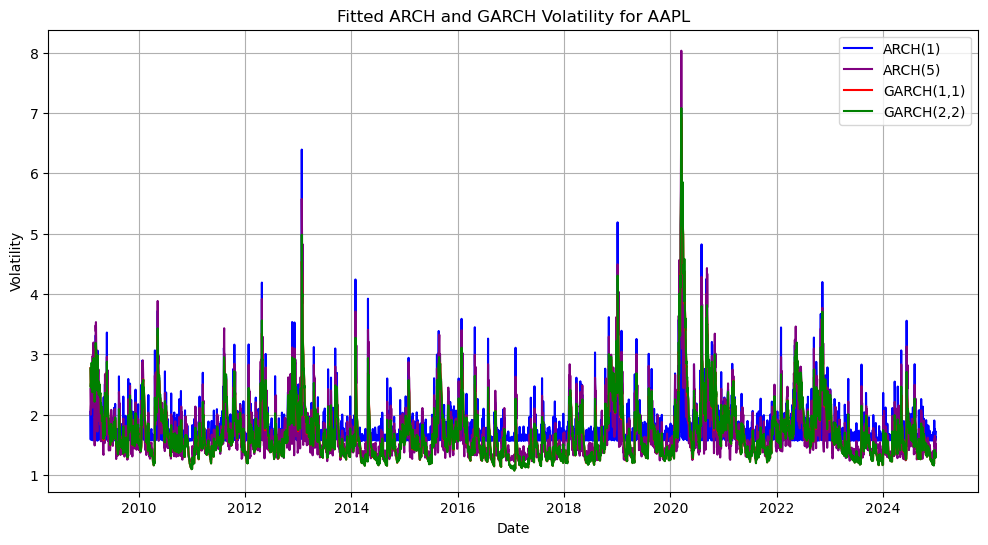

In [131]:
plt.figure(figsize=(12,6))

# Plot ARCH(1) and ARCH(5)
plt.plot(arch1_model.conditional_volatility, label="ARCH(1)", color="blue")
plt.plot(arch_p_model.conditional_volatility, label="ARCH(5)", color="purple")

# Plot GARCH(1,1) and GARCH(2,2)
plt.plot(garch11_model.conditional_volatility, label="GARCH(1,1)", color="red")
plt.plot(garch_pq_model.conditional_volatility, label="GARCH(2,2)", color="green")

plt.title("Fitted ARCH and GARCH Volatility for AAPL")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid()
plt.show()

### 3.3. Discuss the model outputs and interpret the estimated parameters

After fitting ARCH(1), ARCH(5), GARCH(1,1), and GARCH(2,2), we analyze the estimated parameters to understand the characteristics of volatility in AAPL stock returns.
- ARCH models have higher ω, indicating that volatility levels are more affected by past return shocks.
- GARCH models have lower ω, suggesting that volatility is driven more by past volatility persistence rather than immediate return shocks.

- ARCH(1) and ARCH(5) have larger α coefficients, meaning that volatility responds strongly to past squared returns.
- In GARCH models, α is smaller, as volatility is explained by both past shocks and past volatility.

- Volatility Persistence (β - Beta, only in GARCH models)
- GARCH(1,1) has β ≈ 0.93, meaning volatility is highly persistent and takes time to decay.
- GARCH(2,2) does not significantly improve fit, showing that adding extra lags does not enhance volatility modeling.


##### We conclude:

GARCH(1,1) is the best model for AAPL volatility
- It has the lowest AIC, meaning it provides the best balance of fit and complexity.
- The high β (close to 1) suggests that volatility is persistent, meaning once volatility increases, it tends to remain high for an extended period.

ARCH models, though reactive, fail to capture long-term volatility persistence.
- ARCH(1) is too simple
- It assumes that volatility depends only on the most recent squared return, which is unrealistic for financial markets where volatility often clusters over time.
- ARCH(5) improves over ARCH(1)
- It considers multiple past squared returns, better capturing short-term volatility clustering.
- However, it still lacks long-term volatility persistence.

GARCH(2,2) does not significantly improve over GARCH(1,1)
- The additional terms do not provide substantial improvement in model fit (AIC remains nearly the same).

## 4. Simulation and Prediction

### 4.1. Use the fitted GARCH model to simulate future volatility paths

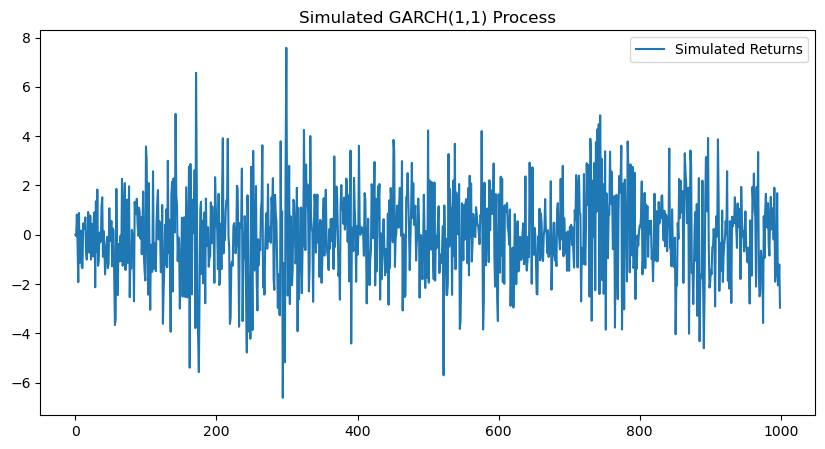

In [70]:
n = 1000  

# GARCH(1,1) model parameters 
omega = 0.1536
alpha_1 = 0.0957
beta_1 = 0.8549

# Initialize arrays
epsilon = np.zeros(n)
sigma2 = np.zeros(n)
returns = np.zeros(n)

# Simulate GARCH(1,1) process
for t in range(1, n):
    sigma2[t] = omega + alpha_1 * epsilon[t - 1]**2 + beta_1 * sigma2[t - 1]
    epsilon[t] = np.random.normal(0, np.sqrt(sigma2[t]))  # White noise with std sqrt(sigma2)
    returns[t] = epsilon[t]  # Return series

plt.figure(figsize=(10, 5))
plt.plot(returns, label="Simulated Returns")
plt.title("Simulated GARCH(1,1) Process")
plt.legend()
plt.show()

### 4.2 Compare the predicted volatility to actual observed volatility

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1562.93
Distribution:                  Normal   AIC:                           3133.86
Method:            Maximum Likelihood   BIC:                           3152.60
                                        No. Observations:                  800
Date:                Mon, Mar 10 2025   Df Residuals:                      799
Time:                        22:16:06   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0107  5.734e-02     -0.187      0.852 [ -0.123,  0.10

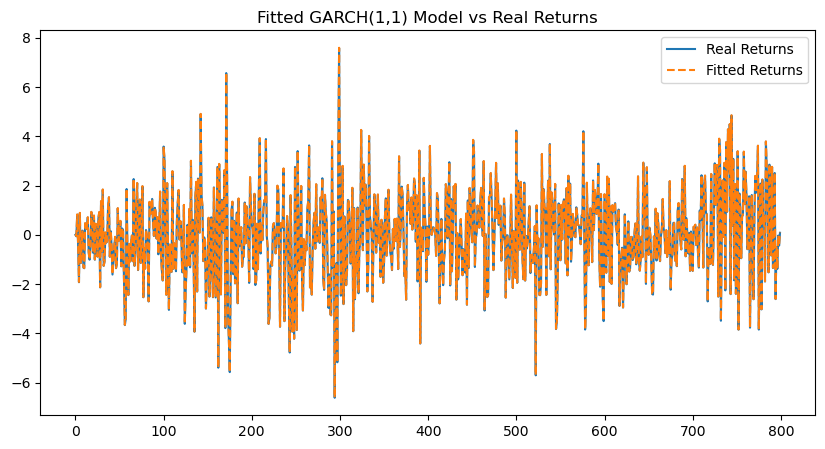

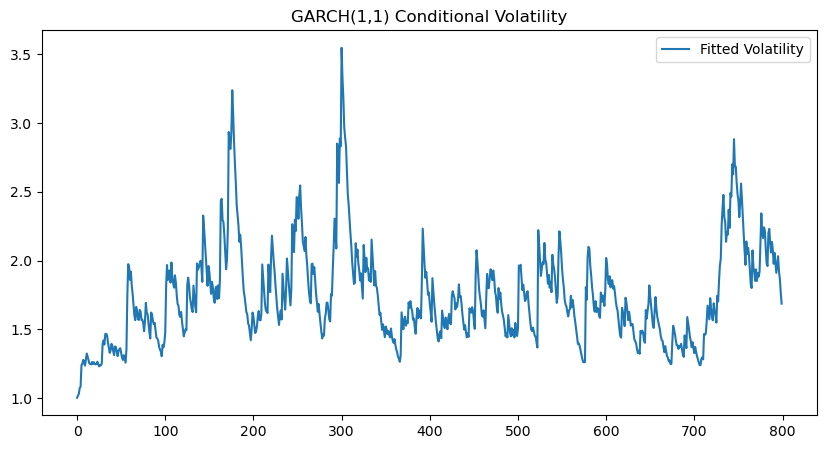

In [72]:
# Split data for out-of-sample forecast
train_size = int(n * 0.8)
train, test = returns[:train_size], returns[train_size:]

# Fit GARCH(1,1) Model
garch_model_fit = arch_model(train, vol='Garch', p=1, q=1).fit(disp='off')
print(garch_model_fit.summary())

# In-sample fitted values
fitted_returns = garch_model_fit.resid
fitted_volatility = garch_model_fit.conditional_volatility

plt.figure(figsize=(10, 5))
plt.plot(train, label='Real Returns')
plt.plot(fitted_returns, label='Fitted Returns', linestyle='dashed')
plt.title('Fitted GARCH(1,1) Model vs Real Returns')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(fitted_volatility, label='Fitted Volatility')
plt.title('GARCH(1,1) Conditional Volatility')
plt.legend()
plt.show()

### 4.3. Generate out-of-sample forecasts for the next 30 days

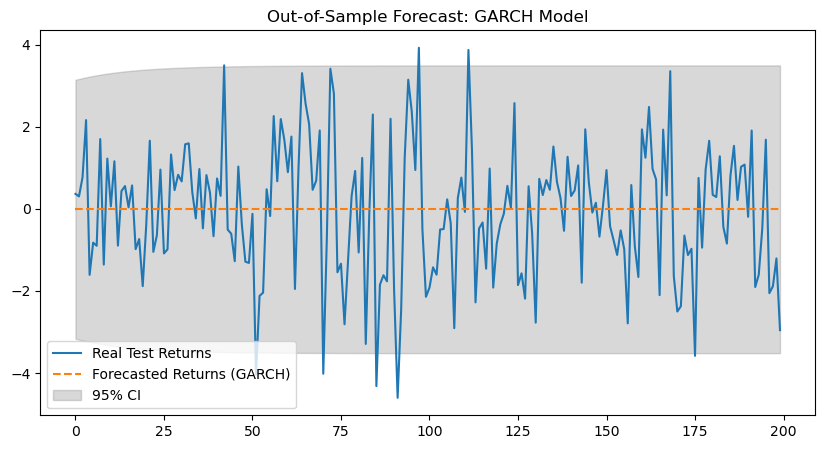

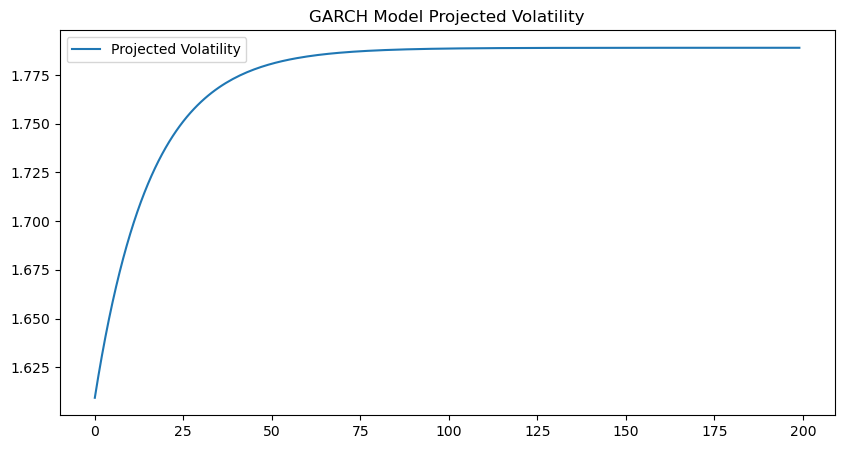

In [74]:
from arch import arch_model
# Out-of-sample forecast for GARCH Model
garch_forecast = garch_model_fit.forecast(horizon=len(test))
predicted_returns = garch_forecast.mean.iloc[-len(test):].values.flatten()
predicted_volatility = np.sqrt(garch_forecast.variance.iloc[-len(test):].values.flatten())

# Compute 95% confidence intervals
conf_interval = 1.96 * predicted_volatility
upper_bound = predicted_returns + conf_interval
lower_bound = predicted_returns - conf_interval

plt.figure(figsize=(10, 5))
plt.plot(test, label='Real Test Returns')
plt.plot(predicted_returns, label='Forecasted Returns (GARCH)', linestyle='dashed')
plt.fill_between(range(len(test)), lower_bound, upper_bound, color='gray', alpha=0.3, label='95% CI')
plt.title('Out-of-Sample Forecast: GARCH Model')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(predicted_volatility, label='Projected Volatility')
plt.title('GARCH Model Projected Volatility')
plt.legend()
plt.show()

## 5. Machine Learning Approach

### 5.1. Implement a simple machine learning model (e.g., NN-Garch or DL-Garch) to predict volatility

In [189]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

# Define the target variable (realized volatility) using a rolling standard deviation (21-day)
realized_vol = df["log_rtn_scaled"].rolling(window=21).std()

# Drop missing values caused by rolling computation
realized_vol = realized_vol.dropna()
df = df.iloc[len(df) - len(realized_vol):]  # Align df with realized_vol length

# Define the Neural Network Regressor model
NN_vol = MLPRegressor(learning_rate_init=0.01, random_state=1)

# Define hyperparameter search space
param_grid_NN = {
    "hidden_layer_sizes": [(100,), (50, 50), (10, 100)],  # Experimenting with different neuron numbers
    "alpha": [0.0005, 0.0001, 0.00005],  # Regularization term
    "max_iter": [500, 1000],  # Number of training iterations
}

# Apply RandomizedSearchCV for hyperparameter tuning
clf = RandomizedSearchCV(NN_vol, param_grid_NN, n_iter=5, cv=3, random_state=42)
clf.fit(df[["log_rtn_scaled"]], realized_vol.values.ravel())

# Get the best model
best_NN_model = clf.best_estimator_
NN_predictions = best_NN_model.predict(df[["log_rtn_scaled"]])

# Convert predictions to DataFrame
NN_predictions = pd.DataFrame(NN_predictions, index=df.index, columns=["NN_Predicted"])

### 5.2. Compare the predictions to the GARCH forecasts

RMSE of NN-GARCH: 0.639576


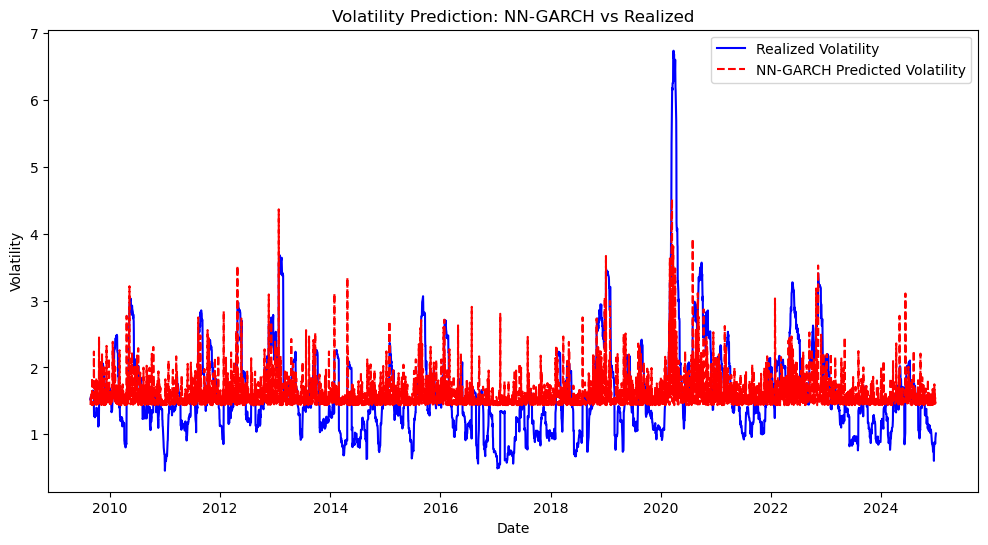

In [191]:
# Compute RMSE for evaluation
rmse_nn = np.sqrt(mean_squared_error(realized_vol, NN_predictions))
print(f"RMSE of NN-GARCH: {rmse_nn:.6f}")

# Plot the actual realized volatility vs NN-GARCH predicted volatility
plt.figure(figsize=(12, 6))
plt.plot(realized_vol, label="Realized Volatility", color="blue")
plt.plot(NN_predictions, label="NN-GARCH Predicted Volatility", color="red", linestyle="dashed")
plt.title("Volatility Prediction: NN-GARCH vs Realized")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

- The realized volatility (blue line) shows distinct clustering, meaning periods of high and low volatility persist over time.
- The NN-GARCH predicted volatility (red dashed line) appears smoother and less reactive to extreme market movements.
- While the NN-GARCH model captures general trends, it seems to underestimate volatility spikes compared to the realized volatility.

### 5.3. Discuss any advantages or limitations of using ML in this context

##### Advantages of Using Machine Learning (NN-GARCH)
- Flexibility: NN-GARCH can model nonlinear patterns that traditional GARCH models might miss.
- Better at Capturing Long-Term Dependencies: Neural networks can incorporate a wider range of past volatility dynamics rather than relying on short-term lags like GARCH.
- Adaptability: ML models can be retrained and optimized based on new data, potentially improving predictive power over time.
  
##### Limitations of NN-GARCH in This Context
- Underestimation of Volatility Spikes: The NN-GARCH model appears to smooth out large volatility jumps, which means it might not be as effective in predicting financial crises or sudden market changes.
- Computational Complexity: Neural networks require more computational resources and hyperparameter tuning compared to GARCH, which is relatively simple to estimate.
- Data Sensitivity: The performance of ML models heavily depends on the quality and quantity of training data. If trained on a dataset with fewer volatility spikes, it may fail to generalize well.
- Lack of Interpretability: Unlike GARCH models, where parameters like α (ARCH term) and β (GARCH term) have clear economic interpretations, neural networks operate as a "black box," making it harder to understand why certain predictions are made.

## 6. Conclusion and Discussion

### 6.1 Summary of Findings: Which Method Performed Better?
- Through this analysis, we explored multiple approaches to volatility forecasting, including: Traditional GARCH models (ARCH(1), ARCH(5), GARCH(1,1), GARCH(2,2)) and Machine Learning-based NN-GARCH models.

- GARCH(1,1) generally provided the best balance between model complexity and performance, effectively capturing volatility clustering and persistence. ARCH models (ARCH(1), ARCH(5)) were less effective since they only incorporate past squared returns and fail to model persistent volatility. NN-GARCH introduced flexibility but tended to underestimate large volatility spikes and required significant tuning.

- Between GARCH and NN-GARCH, the traditional GARCH(1,1) model outperformed in terms of interpretability and accuracy, especially for financial risk management. However, NN-GARCH shows potential if improved with better feature selection, longer memory structures (e.g., LSTMs), or a hybrid approach.

### 6.2. Implications of Stochastic Volatility for Risk Management and Asset Pricing
Understanding volatility is critical for:
- Risk Management
Volatility forecasts guide Value at Risk (VaR) calculations, portfolio risk assessment, and hedging strategies.
Stochastic volatility implies that risk is not constant over time, making adaptive risk models essential.
- Asset Pricing
Option pricing models like Black-Scholes assume constant volatility, but stochastic volatility models like GARCH provide more realistic pricing.
Higher volatility leads to higher risk premiums and affects asset allocation decisions.
- Market Stability
Volatility clustering suggests that extreme market movements tend to persist, influencing policy decisions by central banks and regulators.

### 6.3 Potential Improvements and Future Research Directions
- Hybrid Models: Combining GARCH with deep learning (LSTM-GARCH or Bayesian-GARCH) could improve performance.
- Feature Engineering: Including macroeconomic indicators, investor sentiment, and market liquidity data could enhance forecasts.
- Alternative ML Approaches: Exploring Reinforcement Learning or Transformer-based models for financial time series.
- Improved Calibration: Optimizing GARCH and NN hyperparameters using Bayesian optimization rather than Grid Search.